In [1]:
# CELL 1 — Install packages 


!pip install -q yt-dlp mlxtend
!pip install -q transformers datasets evaluate sentencepiece accelerate
!pip install -q librosa pydub langdetect soundfile
!pip install -q scikit-learn pandas numpy scipy matplotlib seaborn
!pip install -q torch --index-url https://download.pytorch.org/whl/cpu
!pip install -q absl-py rouge-score protobuf

# NLTK data
import nltk
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

print("Packages installed (or previously present).")


Packages installed (or previously present).


In [2]:
# CELL 2 — Imports & device
import os, sys, re, glob, subprocess, shlex, warnings, time
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# HF / audio / NLP
from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    MBartForConditionalGeneration, MBart50TokenizerFast,
)
from datasets import load_dataset
import evaluate

import librosa
from yt_dlp import YoutubeDL

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# NLTK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# sklearn + helpers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
)

from scipy.sparse import csr_matrix, hstack, vstack

# Association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

print("Imports ready.")


Device: cpu
Imports ready.


In [3]:
# CELL 3 — Text cleaning & keywords
def clean_text_basic(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.replace("\n", " ").strip()
    return re.sub(r"\s+", " ", text)

KEYWORDS = [
    "definition", "important", "key point", "in summary",
    "conclusion", "therefore", "result", "note that", "remember"
]

print("Text utilities ready.")


Text utilities ready.


In [4]:
# CELL 4 — Download YouTube audio & ffmpeg conversion
def download_youtube_audio(video_url, out_dir="downloads", filename_stem="audio"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    outtmpl = os.path.join(out_dir, f"{filename_stem}.%(ext)s")
    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": outtmpl,
        "noplaylist": True,
        "quiet": True,
        "no_warnings": True,
        "retries": 3,
        "postprocessors": [
            {"key": "FFmpegExtractAudio", "preferredcodec": "mp3", "preferredquality": "192"}
        ],
    }
    try:
        with YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(video_url, download=True)
            base = os.path.join(out_dir, filename_stem)
            # find the mp3
            candidates = glob.glob(base + ".mp3")
            if candidates:
                print("Audio saved to", candidates[0])
                return candidates[0]
            ext = info.get("ext", "mp3")
            guessed = f"{base}.{ext}"
            if os.path.exists(guessed):
                print("Audio saved to", guessed)
                return guessed
    except Exception as e:
        print("yt-dlp download failed:", e)
        return None

def to_wav16k_mono(in_path, out_path="downloads/audio_clean.wav"):
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    try:
        cmd = f'ffmpeg -y -i {shlex.quote(in_path)} -ac 1 -ar 16000 -vn -f wav {shlex.quote(out_path)}'
        subprocess.run(cmd, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        return out_path
    except Exception as e:
        print("ffmpeg conversion failed (ffmpeg must be in PATH). Falling back to original:", e)
        return in_path

print("YouTube/ffmpeg helpers ready.")


YouTube/ffmpeg helpers ready.


In [5]:
# CELL 5 — Whisper setup & transcribe
print("Loading Whisper model (small)")
whisper_processor = None
whisper_model = None
try:
    whisper_model_id = "openai/whisper-small"
    whisper_processor = WhisperProcessor.from_pretrained(whisper_model_id)
    whisper_model = WhisperForConditionalGeneration.from_pretrained(whisper_model_id).to(device)
    print("Whisper loaded.")
except Exception as e:
    print("Whisper load failed:", e)
    print("You can continue but ASR-dependent steps will fail until Whisper loads.")

def _detect_lang_code(text: str) -> str:
    if not text or not text.strip():
        return "en"
    try:
        code = detect(text)
        return "hi" if code.startswith("hi") else "en"
    except Exception:
        return "en"

def transcribe_chunks(audio_path, language=None, chunk_seconds=10):
    if whisper_processor is None or whisper_model is None:
        raise RuntimeError("Whisper not loaded.")
    wav_path = to_wav16k_mono(audio_path)
    y_full, sr = librosa.load(wav_path, sr=16000, mono=True)
    probe = y_full[:30*sr]
    feats = whisper_processor(probe, sampling_rate=sr, return_tensors="pt").input_features.to(device)
    seq = whisper_model.generate(feats, do_sample=False, temperature=0.0)
    first_text = whisper_processor.batch_decode(seq, skip_special_tokens=True)[0].strip()
    auto_lang = _detect_lang_code(first_text)
    lang_forced = language if language in ("en","hi") else auto_lang
    print(f"Auto-detected: {auto_lang.upper()} → Forcing: {lang_forced.upper()}")
    forced_ids = whisper_processor.get_decoder_prompt_ids(language=lang_forced, task="transcribe")
    step = chunk_seconds * sr
    results = []
    for i in range(0, len(y_full), step):
        chunk = y_full[i:i+step]
        if len(chunk) < sr: continue
        inputs = whisper_processor(chunk, sampling_rate=sr, return_tensors="pt").input_features.to(device)
        gen = whisper_model.generate(
            inputs,
            forced_decoder_ids=forced_ids,
            do_sample=False, temperature=0.0, num_beams=1,
            no_repeat_ngram_size=3, repetition_penalty=1.15, length_penalty=1.0
        )
        text = whisper_processor.batch_decode(gen, skip_special_tokens=True)[0].strip()
        if text:
            results.append({"text": text, "lang": lang_forced})
    return results

def transcribe_audio(audio_path, language=None):
    print(" Transcribing audio in chunks...")
    chunks = transcribe_chunks(audio_path, language=language, chunk_seconds=10)
    full_text = " ".join(c["text"] for c in chunks).strip()
    maj = "hi" if sum(c["lang"]=="hi" for c in chunks) > len(chunks)/2 else "en"
    print("Chunk-majority language:", maj)
    return full_text, maj, chunks

print("Whisper transcription helpers ready (if model loaded).")


Loading Whisper model (small)
Whisper loaded.
Whisper transcription helpers ready (if model loaded).


In [6]:
# CELL 6 — BART (abstractive) + mBART (translation)
print("Loading BART (facebook/bart-large-cnn).")
summ_tokenizer_en = None
summ_model_en = None
try:
    summ_tokenizer_en = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
    summ_model_en = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)
    print("BART loaded.")
except Exception as e:
    print("Failed to load BART:", e)

print("Loading mBART-50 for EN<->HI translation (may require protobuf).")
mbart_tokenizer = None
mbart_model = None
try:
    mbart_name = "facebook/mbart-large-50-many-to-many-mmt"
    mbart_tokenizer = MBart50TokenizerFast.from_pretrained(mbart_name)
    mbart_model = MBartForConditionalGeneration.from_pretrained(mbart_name).to(device)
    print("mBART-50 loaded.")
except Exception as e:
    print("mBART load failed (protobuf may be missing):", e)
    print("If you need Hindi translation, run: pip install protobuf and restart the kernel.")

def translate_text_mb(text: str, src_lang: str, tgt_lang: str, max_len: int = 1024) -> str:
    if mbart_tokenizer is None or mbart_model is None:
        raise RuntimeError("mBART not loaded.")
    text = clean_text_basic(text)
    if not text:
        return ""
    mbart_tokenizer.src_lang = src_lang
    enc = mbart_tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len).to(device)
    gen = mbart_model.generate(
        **enc,
        forced_bos_token_id=mbart_tokenizer.lang_code_to_id[tgt_lang],
        max_length=min(1024, max_len+50)
    )
    return mbart_tokenizer.batch_decode(gen, skip_special_tokens=True)[0]


Loading BART (facebook/bart-large-cnn).
BART loaded.
Loading mBART-50 for EN<->HI translation (may require protobuf).


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

mBART-50 loaded.


In [7]:
# CELL 7 — Abstractive summary & improved abstractive by feeding extractive summary

def generate_abstractive_summary(text: str, max_tokens: int = 256) -> str:
    """
    Basic BART summarization on English text. If summ_model_en not available, returns "".
    """
    if summ_model_en is None or summ_tokenizer_en is None:
        print("BART not loaded; cannot generate abstractive summary.")
        return ""
    text = clean_text_basic(text)
    if not text:
        return ""
    inputs = summ_tokenizer_en(text, max_length=1024, truncation=True, return_tensors="pt").to(device)
    summary_ids = summ_model_en.generate(
        inputs['input_ids'],
        max_length=max_tokens, min_length=60, num_beams=4, length_penalty=2.0, early_stopping=True
    )
    return summ_tokenizer_en.decode(summary_ids[0], skip_special_tokens=True)

def generate_improved_abstractive(extractive_summary: str, original_transcript: str, max_tokens: int = 256) -> str:
    """
    Take the extractive summary (short) and original transcript, and ask BART to generate
    a refined abstractive summary by providing the extractive summary as context.
    Approach: create a prompt: [EXTRACTIVE SUMMARY]\n\n[TRANSCRIPT]
    This gives BART a concise content highlight to guide the abstractive generation.
    """
    if summ_model_en is None or summ_tokenizer_en is None:
        print("BART not loaded; cannot produce improved abstractive summary.")
        return ""
    # prepare prompt: extractive prefixed (short), then transcript
    prompt = ""
    if extractive_summary and len(extractive_summary.strip()) > 10:
        prompt = f"ExtractiveSummary: {clean_text_basic(extractive_summary)}\n\nTranscript: {clean_text_basic(original_transcript)}"
    else:
        prompt = clean_text_basic(original_transcript)
    # Truncate prompt if too long
    prompt = prompt[:30000]  # be conservative
    inputs = summ_tokenizer_en(prompt, max_length=1024, truncation=True, return_tensors="pt").to(device)
    summary_ids = summ_model_en.generate(
        inputs['input_ids'],
        max_length=max_tokens, min_length=60, num_beams=4, length_penalty=2.0, early_stopping=True
    )
    return summ_tokenizer_en.decode(summary_ids[0], skip_special_tokens=True)

print("Abstractive and improved-abstractive functions ready.")


Abstractive and improved-abstractive functions ready.


In [8]:
# CELL 8 — Load cnn_dailymail dataset for supervised extractive training
print("Loading CNN/DailyMail (may take time to download)...")
try:
    cnn_data = load_dataset("cnn_dailymail", "3.0.0")
    train_raw = cnn_data["train"]
    val_raw = cnn_data["validation"]
    test_raw = cnn_data["test"]
    print("Loaded CNN/DailyMail splits. Sizes:", len(train_raw), len(val_raw), len(test_raw))
except Exception as e:
    print("Failed to load cnn_dailymail:", e)
    train_raw = val_raw = test_raw = None


Loading CNN/DailyMail (may take time to download)...
Loaded CNN/DailyMail splits. Sizes: 287113 13368 11490


In [9]:
# CELL 9 — Build sentence-importance dataset for sentence classifier
NUM_DOCS_FOR_SENTENCES = 2000
OVERLAP_THRESHOLD = 0.4

def sentence_overlaps_summary(sent: str, summary: str, threshold: float = OVERLAP_THRESHOLD) -> int:
    sent_tokens = set([t.lower() for t in word_tokenize(sent) if t.isalnum()])
    if not sent_tokens:
        return 0
    summ_tokens = set([t.lower() for t in word_tokenize(summary) if t.isalnum()])
    overlap = len(sent_tokens & summ_tokens) / len(sent_tokens)
    return 1 if overlap >= threshold else 0

def build_sentence_importance_dataset(dataset, num_docs=NUM_DOCS_FOR_SENTENCES, overlap_threshold=OVERLAP_THRESHOLD):
    sentences = []
    labels = []
    lengths = []
    positions = []
    keyword_flags = []
    n_docs = min(num_docs, len(dataset))
    for i in range(n_docs):
        art = dataset[i]["article"]
        summ = dataset[i]["highlights"]
        if not art or not summ:
            continue
        art_clean = clean_text_basic(art)
        summ_clean = clean_text_basic(summ)
        sents = sent_tokenize(art_clean)
        total = len(sents)
        if total == 0:
            continue
        for idx, s in enumerate(sents):
            s_clean = clean_text_basic(s)
            if not s_clean:
                continue
            label = sentence_overlaps_summary(s_clean, summ_clean, threshold=overlap_threshold)
            sentences.append(s_clean)
            labels.append(label)
            lengths.append(len(s_clean.split()))
            positions.append(idx / total)
            keyword_flags.append(1 if any(kw in s_clean.lower() for kw in KEYWORDS) else 0)
    print(f"Built sentence dataset: {len(sentences)} sentences. Important: {sum(labels)}")
    return sentences, np.array(labels), np.array(lengths), np.array(positions), np.array(keyword_flags)

if train_raw is not None:
    sentences_all, labels_all, lengths_all, positions_all, keyword_flags_all = build_sentence_importance_dataset(train_raw, num_docs=NUM_DOCS_FOR_SENTENCES, overlap_threshold=OVERLAP_THRESHOLD)
else:
    sentences_all = labels_all = lengths_all = positions_all = keyword_flags_all = None


Built sentence dataset: 64569 sentences. Important: 8303


In [10]:
# CELL 10 — TF-IDF + numeric features + train/val/test split
MAX_TFIDF_FEATURES = 5000

if sentences_all is None:
    print("No sentence dataset. Re-run dataset load.")
else:
    tfidf_sent = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, stop_words="english")
    X_tfidf_sent = tfidf_sent.fit_transform(sentences_all)
    numeric_feats = np.vstack([lengths_all, positions_all, keyword_flags_all]).T
    numeric_sparse = csr_matrix(numeric_feats)
    X_all = hstack([X_tfidf_sent, numeric_sparse])
    y_all = labels_all

    X_temp, X_test_s, y_temp, y_test_s = train_test_split(X_all, y_all, test_size=0.15, random_state=42, stratify=y_all)
    val_ratio = 0.15 / 0.85
    X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp)

    print("Split sizes: Train", X_train_s.shape, "Val", X_val_s.shape, "Test", X_test_s.shape)


Split sizes: Train (45197, 5003) Val (9686, 5003) Test (9686, 5003)


In [11]:
# CELL 11 — Train classical classifiers + MLP (pick best by val F1)
results_sentence_cls = []

def eval_classification_model(model, name, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    def metrics(X,y):
        y_pred = model.predict(X)
        return {
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred, zero_division=0),
            "recall": recall_score(y, y_pred, zero_division=0),
            "f1": f1_score(y, y_pred, zero_division=0)
        }
    val_m = metrics(X_val, y_val)
    test_m = metrics(X_te, y_te)
    print(f"[{name}] Val F1: {val_m['f1']:.4f}, Test F1: {test_m['f1']:.4f}")
    return {"name": name, "model": model, "val": val_m, "test": test_m}

models_to_try = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Naïve Bayes", MultinomialNB()),
    ("KNN (k=5)", KNeighborsClassifier(n_neighbors=5)),
    ("Linear SVM", LinearSVC(max_iter=10000)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

for name, m in models_to_try:
    try:
        res = eval_classification_model(m, name, X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s)
        results_sentence_cls.append(res)
    except Exception as e:
        print("Failed training", name, ":", e)

# MLP (shallow)
try:
    X_tr_dense = X_train_s.toarray()
    X_val_dense = X_val_s.toarray()
    X_test_dense = X_test_s.toarray()
    max_mlp_samples = 8000
    if X_tr_dense.shape[0] > max_mlp_samples:
        X_tr_mlp = X_tr_dense[:max_mlp_samples]; y_tr_mlp = y_train_s[:max_mlp_samples]
    else:
        X_tr_mlp = X_tr_dense; y_tr_mlp = y_train_s
    mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=20, random_state=42)
    mlp_res = eval_classification_model(mlp, "MLP (Shallow)", X_tr_mlp, y_tr_mlp, X_val_dense, y_val_s, X_test_dense, y_test_s)
    results_sentence_cls.append(mlp_res)
except Exception as e:
    print("Skipping MLP due to:", e)

# Summarize and pick best by validation F1
df_models = []
for r in results_sentence_cls:
    df_models.append({"name": r["name"], "val_f1": r["val"]["f1"], "val_acc": r["val"]["accuracy"], "val_prec": r["val"]["precision"], "val_rec": r["val"]["recall"]})
df_models = pd.DataFrame(df_models).sort_values("val_f1", ascending=False).reset_index(drop=True)
print("\nModel comparison (validation):")
print(df_models.to_string(index=False))

best_model_name = df_models.loc[0, "name"]
best_entry = next(r for r in results_sentence_cls if r["name"] == best_model_name)
final_sentence_model = best_entry["model"]
print("Selected best model by validation F1:", best_model_name)


[Logistic Regression] Val F1: 0.0818, Test F1: 0.0881
[Naïve Bayes] Val F1: 0.0064, Test F1: 0.0032
[KNN (k=5)] Val F1: 0.1192, Test F1: 0.1044
[Linear SVM] Val F1: 0.1425, Test F1: 0.1580
[Random Forest] Val F1: 0.1789, Test F1: 0.1721
[MLP (Shallow)] Val F1: 0.1623, Test F1: 0.1936

Model comparison (validation):
               name   val_f1  val_acc  val_prec  val_rec
      Random Forest 0.178918 0.877762  0.654822 0.103614
      MLP (Shallow) 0.162338 0.840182  0.248756 0.120482
         Linear SVM 0.142469 0.869502  0.458515 0.084337
          KNN (k=5) 0.119241 0.865786  0.380952 0.070683
Logistic Regression 0.081756 0.874768  0.710526 0.043373
        Naïve Bayes 0.006390 0.871567  0.571429 0.003213
Selected best model by validation F1: Random Forest


In [12]:
# CELL 12 — Fusion attempt and retrain balanced models + threshold tuning on val

# Fusion of top-3 by val_f1
top_k = min(3, len(df_models))
top_models = df_models.head(top_k)["name"].tolist()
fusion_models = [(r["name"], r["model"]) for r in results_sentence_cls if r["name"] in top_models]

def fusion_predict_proba(models, X):
    probs = []
    for name, m in models:
        if hasattr(m, "predict_proba"):
            p = m.predict_proba(X)[:,1]
        elif hasattr(m, "decision_function"):
            df = m.decision_function(X)
            p = 1/(1+np.exp(-df))
        else:
            p = m.predict(X).astype(float)
        probs.append(p)
    avg = np.vstack(probs).mean(axis=0)
    return avg

use_fusion = False
try:
    fusion_probs_val = fusion_predict_proba(fusion_models, X_val_s)
    fusion_preds_val = (fusion_probs_val >= 0.5).astype(int)
    fusion_f1 = f1_score(y_val_s, fusion_preds_val, zero_division=0)
    best_val_f1 = df_models.loc[0, "val_f1"]
    if fusion_f1 > best_val_f1:
        use_fusion = True
        print("Fusion outperforms best single model on val. Using fusion.")
    else:
        print("Fusion did not improve validation F1; will use single best model.")
except Exception as e:
    print("Fusion failed:", e)
    use_fusion = False

# Retrain balanced Logistic and RandomForest and tune threshold on validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_tr = X_train_s; X_val = X_val_s; X_te = X_test_s
y_tr = y_train_s; y_val = y_val_s; y_te = y_test_s

lr_bal = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_bal.fit(X_tr, y_tr)
rf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_bal.fit(X_tr, y_tr)

retrained_models = {"LogisticBalanced": lr_bal, "RandomForestBalanced": rf_bal}

def get_probs(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    elif hasattr(model, "decision_function"):
        return 1/(1+np.exp(-model.decision_function(X)))
    else:
        return model.predict(X).astype(float)

best_results = {}
for name, m in retrained_models.items():
    probs_val = get_probs(m, X_val)
    best = (0.0, 0.5, 0.0, 0.0)
    for t in np.linspace(0.01, 0.99, 99):
        preds = (probs_val >= t).astype(int)
        f1t = f1_score(y_val, preds, zero_division=0)
        if f1t > best[0]:
            best = (f1t, t, precision_score(y_val, preds, zero_division=0), recall_score(y_val, preds, zero_division=0))
    best_results[name] = best
    print(f"{name}: best VAL F1 {best[0]:.4f} @ thresh {best[1]:.3f} (prec {best[2]:.3f}, rec {best[3]:.3f})")

# pick best retrained model
best_name = max(best_results.keys(), key=lambda k: best_results[k][0])
best_f1, best_thresh, _, _ = best_results[best_name]
best_model = retrained_models[best_name]
probs_test = get_probs(best_model, X_te)
preds_test = (probs_test >= best_thresh).astype(int)
print(f"\n*** Final chosen retrained model: {best_name} (val F1 {best_f1:.4f}) ***")
print("Test set classification report:")
print(classification_report(y_te, preds_test, zero_division=0))
print("Confusion matrix (test):\n", confusion_matrix(y_te, preds_test))

# Lock final model and threshold
final_sentence_model = best_model
best_threshold = float(best_thresh)
print("Final model:", type(final_sentence_model).__name__, "threshold:", best_threshold)


Fusion did not improve validation F1; will use single best model.
LogisticBalanced: best VAL F1 0.3437 @ thresh 0.550 (prec 0.256, rec 0.524)
RandomForestBalanced: best VAL F1 0.3732 @ thresh 0.150 (prec 0.278, rec 0.568)

*** Final chosen retrained model: RandomForestBalanced (val F1 0.3732) ***
Test set classification report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      8440
           1       0.27      0.56      0.37      1246

    accuracy                           0.75      9686
   macro avg       0.60      0.67      0.60      9686
weighted avg       0.84      0.75      0.78      9686

Confusion matrix (test):
 [[6540 1900]
 [ 543  703]]
Final model: RandomForestClassifier threshold: 0.15000000000000002


In [13]:
# CELL 13 — featurize_sentences_for_importance (used by extractive builder)
def featurize_sentences_for_importance(sent_list):
    if not sent_list:
        return None
    if 'tfidf_sent' not in globals():
        raise RuntimeError("tfidf_sent not found. Re-run TF-IDF cell (Cell 10).")
    sent_list_clean = [clean_text_basic(s) for s in sent_list]
    total = max(1, len(sent_list_clean))
    lengths = np.array([len(s.split()) for s in sent_list_clean], dtype=float)
    positions = np.array([i/total for i in range(total)], dtype=float)
    keyword_flags = np.array([1 if any(kw in s.lower() for kw in KEYWORDS) else 0 for s in sent_list_clean], dtype=float)
    X_tfidf = tfidf_sent.transform(sent_list_clean)
    numeric = np.vstack([lengths, positions, keyword_flags]).T
    numeric_sparse = csr_matrix(numeric)
    X_feat = hstack([X_tfidf, numeric_sparse], format='csr')
    return X_feat

print("featurize_sentences_for_importance ready.")


featurize_sentences_for_importance ready.


In [14]:
# CELL 14 — Build regression dataset & train linear / polynomial regressors
def build_regression_dataset(dataset, num_docs=1500):
    doc_features = []
    targets = []
    n_docs = min(num_docs, len(dataset))
    for i in range(n_docs):
        art = dataset[i]["article"]; summ = dataset[i]["highlights"]
        if not art or not summ: continue
        art_clean = clean_text_basic(art); summ_clean = clean_text_basic(summ)
        art_sents = sent_tokenize(art_clean); summ_sents = sent_tokenize(summ_clean)
        num_words_art = len(art_clean.split()); num_sents_art = len(art_sents)
        avg_sent_len = num_words_art / num_sents_art if num_sents_art>0 else 0
        num_sents_summ = len(summ_sents)
        if num_sents_art==0 or num_sents_summ==0: continue
        doc_features.append([num_words_art, num_sents_art, avg_sent_len])
        targets.append(num_sents_summ)
    X = np.array(doc_features, dtype=float); y = np.array(targets, dtype=float)
    print("Regression dataset:", X.shape[0], "docs")
    return X,y

if train_raw is not None:
    X_reg_all, y_reg_all = build_regression_dataset(train_raw, num_docs=1500)
    X_temp_r, X_test_r, y_temp_r, y_test_r = train_test_split(X_reg_all, y_reg_all, test_size=0.15, random_state=42)
    val_ratio_r = 0.15 / 0.85
    X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_temp_r, y_temp_r, test_size=val_ratio_r, random_state=42)
    # Linear and polynomial
    lin = LinearRegression(); lin.fit(X_train_r, y_train_r)
    from sklearn.metrics import mean_squared_error
    def reg_metrics(model, X, y):
        pred = model.predict(X)
        return np.sqrt(mean_squared_error(y,pred)), np.mean(np.abs(y-pred)), r2_score(y,pred)
    print("Linear val RMSE, MAE, R2:", reg_metrics(lin, X_val_r, y_val_r))
    poly = Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)), ("lin", LinearRegression())])
    poly.fit(X_train_r, y_train_r)
    print("Poly val RMSE, MAE, R2:", reg_metrics(poly, X_val_r, y_val_r))
    # choose best by val RMSE
    if reg_metrics(lin, X_val_r, y_val_r)[0] <= reg_metrics(poly, X_val_r, y_val_r)[0]:
        final_reg_model = lin
        print("Selected Linear Regression for length prediction.")
    else:
        final_reg_model = poly
        print("Selected Polynomial Regression for length prediction.")
else:
    final_reg_model = None
    print("No training dataset for regression.")


Regression dataset: 1500 docs
Linear val RMSE, MAE, R2: (np.float64(0.6360945944913299), np.float64(0.5514425777240851), 0.05200991598558369)
Poly val RMSE, MAE, R2: (np.float64(0.6380768864065656), np.float64(0.5482957352115558), 0.046092176061165446)
Selected Linear Regression for length prediction.


In [15]:
# CELL 15 — KMeans clustering on article corpus + Apriori association rules
def build_article_corpus(dataset, num_docs=300):
    arts = []
    for i in range(min(num_docs, len(dataset))):
        a = dataset[i]["article"]
        if a: arts.append(clean_text_basic(a))
    return arts

if train_raw is not None:
    articles_for_cluster = build_article_corpus(train_raw, num_docs=300)
    tfidf_art = TfidfVectorizer(max_features=5000, stop_words="english")
    X_art = tfidf_art.fit_transform(articles_for_cluster)
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_cluster = kmeans.fit_predict(X_art)
    print("KMeans cluster sizes:", np.bincount(labels_cluster))
    # top terms per cluster (centroids)
    try:
        feat = tfidf_art.get_feature_names_out()
        for c in range(k):
            centroid = kmeans.cluster_centers_[c]
            top_idx = centroid.argsort()[::-1][:10]
            print(f"Cluster {c} top terms:", ", ".join(feat[j] for j in top_idx))
    except Exception:
        pass

    # Association rules (Apriori) from top TF-IDF keywords per article
    def build_transactions_from_articles(articles, top_k_terms=8):
        vec = TfidfVectorizer(max_features=3000, stop_words="english")
        X = vec.fit_transform(articles)
        feature_names = vec.get_feature_names_out()
        transactions = []
        for i in range(X.shape[0]):
            row = X[i].toarray().ravel()
            top_idx = row.argsort()[::-1][:top_k_terms]
            terms = [feature_names[j] for j in top_idx]
            transactions.append(list(set(terms)))
        return transactions
    transactions = build_transactions_from_articles(articles_for_cluster, top_k_terms=8)
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_trans = pd.DataFrame(te_ary, columns=te.columns_)
    freq_items = apriori(df_trans, min_support=0.05, use_colnames=True)
    rules = association_rules(freq_items, metric="confidence", min_threshold=0.6)
    print("Apriori rules (top 5):")
    print(rules.sort_values("confidence", ascending=False).head(5))
else:
    print("Skipping clustering/Apriori — no dataset.")


KMeans cluster sizes: [ 30  76  62  30 102]
Cluster 0 top terms: match, season, milan, league, celtic, champions, minutes, win, victory, second
Cluster 1 top terms: said, stiles, vick, says, mother, children, court, year, diana, girl
Cluster 2 top terms: said, police, san, people, department, county, cnn, fires, diego, 000
Cluster 3 top terms: said, interpol, military, children, bangladesh, baku, air, group, government, spokesman
Cluster 4 top terms: said, president, bush, iraq, obama, clinton, pakistan, lebanon, percent, cnn
Apriori rules (top 5):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


In [16]:
# CELL 16 — Build extractive summary from sentences using tuned model & threshold
def suggest_summary_length_from_reg(transcript: str) -> int:
    text = clean_text_basic(transcript)
    sents = sent_tokenize(text)
    if not sents:
        return 1
    num_words = len(text.split())
    num_sents = len(sents)
    avg_len = num_words / num_sents if num_sents>0 else 0
    if 'final_reg_model' in globals() and final_reg_model is not None:
        try:
            X_feat = np.array([[num_words, num_sents, avg_len]], dtype=float)
            pred = final_reg_model.predict(X_feat)[0]
            pred = max(1, int(round(pred)))
            return pred
        except Exception:
            pass
    return max(1, int(round(num_words / 100.0)))

def build_extractive_summary_from_sentences(sentences, target_len=None, threshold=None, pad_with_top=True):
    if not sentences:
        return ""
    if threshold is None:
        threshold = globals().get('best_threshold', 0.5)
    if target_len is None:
        target_len = suggest_summary_length_from_reg(" ".join(sentences))
    X_feat = featurize_sentences_for_importance(sentences)
    if X_feat is None:
        return ""
    model = final_sentence_model
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_feat)[:,1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_feat)
        probs = 1/(1+np.exp(-df))
    else:
        preds = model.predict(X_feat).astype(float); probs = preds
    probs = np.asarray(probs).ravel()
    idxs_above = np.where(probs >= threshold)[0].tolist()
    if len(idxs_above) > target_len:
        idxs_sorted = sorted(idxs_above, key=lambda i: probs[i], reverse=True)[:target_len]
    elif len(idxs_above)==0 and pad_with_top:
        idxs_sorted = list(np.argsort(probs)[::-1][:target_len])
    else:
        idxs_sorted = list(sorted(idxs_above))
        if pad_with_top and len(idxs_sorted) < target_len:
            remaining = [i for i in np.argsort(probs)[::-1] if i not in idxs_sorted]
            to_add = remaining[: max(0, target_len - len(idxs_sorted))]
            idxs_sorted = sorted(idxs_sorted + to_add)
    chosen = [sentences[i] for i in idxs_sorted]
    return " ".join(chosen)

print("Extractive builder ready (uses final_sentence_model and best_threshold).")


Extractive builder ready (uses final_sentence_model and best_threshold).


In [17]:
# CELL 17 — Hybrid pipeline: deep abstractive + classical extractive + improved abstractive
def generate_auto_notes_hybrid(youtube_url, output_language="english", audio_language=None):
    print("="*70); print("AUTO-NOTES HYBRID (Deep + Classical + Improved BART)"); print("="*70)
    # download
    audio_path = download_youtube_audio(youtube_url)
    if not audio_path:
        print("Download failed.")
        return None
    # transcribe
    try:
        transcript_original, maj_lang, chunks = transcribe_audio(audio_path, language=audio_language)
    except Exception as e:
        print("Transcription failed:", e)
        return None
    print("\nOriginal Transcript (snippet):", transcript_original[:300], "...\n")
    # Deep abstractive (EN) + mBART HI if requested
    input_lang = "hi" if maj_lang=="hi" else "en"
    # If transcript in Hindi and mBART available, translate to English for BART
    transcript_for_bart = transcript_original
    if maj_lang=="hi":
        if mbart_model is not None:
            try:
                transcript_for_bart = translate_text_mb(clean_text_basic(transcript_original), src_lang="hi_IN", tgt_lang="en_XX")
            except Exception as e:
                print("Translation to EN failed:", e)
        else:
            transcript_for_bart = clean_text_basic(transcript_original)
    # BART abstractive
    abstractive_en = ""
    if summ_model_en is not None:
        abstractive_en = generate_abstractive_summary(transcript_for_bart, max_tokens=256)
        print("Abstractive (BART) summary generated.")
    else:
        print("BART not available; skipping abstractive.")
    # Extractive (classical)
    # Prepare English sentences for extractive pipeline (if transcript in HI and mbart exists we already translated)
    transcript_en_for_ml = transcript_for_bart
    sentences_en = sent_tokenize(transcript_en_for_ml)
    target_len = suggest_summary_length_from_reg(transcript_en_for_ml)
    extractive_en = build_extractive_summary_from_sentences(sentences_en, target_len=target_len, threshold=best_threshold)
    print("Extractive summary (classical) generated.")
    # Improved abstractive: feed extractive -> BART to refine abstractive
    improved_abstractive_en = ""
    if summ_model_en is not None:
        improved_abstractive_en = generate_improved_abstractive(extractive_en, transcript_for_bart, max_tokens=256)
        print("Improved abstractive (BART with extractive context) generated.")
    # Optional translate outputs to Hindi (if requested)
    abstractive_hi = ""
    improved_abstractive_hi = ""
    extractive_hi = ""
    if output_language.lower().startswith("hi"):
        if mbart_model is not None:
            try:
                abstractive_hi = translate_text_mb(abstractive_en, src_lang="en_XX", tgt_lang="hi_IN") if abstractive_en else ""
            except Exception:
                abstractive_hi = ""
            try:
                improved_abstractive_hi = translate_text_mb(improved_abstractive_en, src_lang="en_XX", tgt_lang="hi_IN") if improved_abstractive_en else ""
            except Exception:
                improved_abstractive_hi = ""
            try:
                extractive_hi = translate_text_mb(extractive_en, src_lang="en_XX", tgt_lang="hi_IN") if extractive_en else ""
            except Exception:
                extractive_hi = ""
        else:
            print("mBART not available; skipping Hindi translations.")
    # Compose results
    result = {
        "transcript_original": transcript_original,
        "majority_lang": maj_lang,
        "abstractive_en": abstractive_en,
        "improved_abstractive_en": improved_abstractive_en,
        "extractive_en": extractive_en,
        "abstractive_hi": abstractive_hi,
        "improved_abstractive_hi": improved_abstractive_hi,
        "extractive_hi": extractive_hi,
        "summary_length_suggested": target_len
    }
    print("Hybrid pipeline complete.")
    return result

print("Hybrid wrapper ready.")


Hybrid wrapper ready.


In [18]:
# CELL 18 — Example- Run hybrid and show the 3 summaries separately
YOUTUBE_URL = "https://youtu.be/kiiA6WTCQn0?si=qwF1apg8fs131qC0"  

res = generate_auto_notes_hybrid(YOUTUBE_URL, output_language="english", audio_language=None)

if not res:
    print("No result produced. Check earlier cells for errors.")
else:
    print("\n" + "="*60)
    print(" ORIGINAL ABSTRACTIVE SUMMARY (BART)")
    print("="*60 + "\n")
    print(res.get("abstractive_en", "") or "[empty]")
    print("\n" + "="*60)
    print(" EXTRACTIVE SUMMARY (Classical ML)")
    print("="*60 + "\n")
    print(res.get("extractive_en", "") or "[empty]")
    print("\n" + "="*60)
    print(" IMPROVED ABSTRACTIVE (Extractive fed -> BART)")
    print("="*60 + "\n")
    print(res.get("improved_abstractive_en", "") or "[empty]")
    print("\n" + "="*60)

    # Save outputs (three separate sections)
    fname = "auto_notes_output_comparison.txt"
    with open(fname, "w", encoding="utf-8") as f:
        f.write("ORIGINAL ABSTRACTIVE (BART)\n")
        f.write("="*60 + "\n")
        f.write(res.get("abstractive_en","") + "\n\n")
        f.write("EXTRACTIVE (Classical ML)\n")
        f.write("="*60 + "\n")
        f.write(res.get("extractive_en","") + "\n\n")
        f.write("IMPROVED ABSTRACTIVE (Extractive -> BART)\n")
        f.write("="*60 + "\n")
        f.write(res.get("improved_abstractive_en","") + "\n\n")
        f.write("FULL TRANSCRIPT\n")
        f.write("="*60 + "\n")
        f.write(res.get("transcript_original","") + "\n\n")
    print("Saved comparison output to", fname)



AUTO-NOTES HYBRID (Deep + Classical + Improved BART)
Audio saved to downloads\audio.mp3                       
 Transcribing audio in chunks...
ffmpeg conversion failed (ffmpeg must be in PATH). Falling back to original: Command 'ffmpeg -y -i 'downloads\audio.mp3' -ac 1 -ar 16000 -vn -f wav downloads/audio_clean.wav' returned non-zero exit status 4294967294.


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Auto-detected: EN → Forcing: EN
Chunk-majority language: en

Original Transcript (snippet): Music Hey friends! Welcome to the YouTube channel all about electronics. So in this video, we are going talk about basics of operational amplifier and upcoming videos talk more about this operational amplifier and we will see how can design the different circuits using this operational amplifier. So ...

Abstractive (BART) summary generated.
Extractive summary (classical) generated.
Improved abstractive (BART with extractive context) generated.
Hybrid pipeline complete.

 ORIGINAL ABSTRACTIVE SUMMARY (BART)

Operational amplifier is basic layer amplifier and the basic job of any amplifier is to amplify the input signal. In early days when digital computers were not evolved at that time the different mathematical functions like addition, subtraction, integration and differentiation where perform using this operational amplifier. The gain of these operational amplifiers is A then output will be eq

In [21]:

# CELL 19 — Load ROUGE and other evaluation metrics

print("Loading evaluation metrics...")
try:
    rouge_metric = evaluate.load("rouge")
    print("ROUGE metric loaded successfully")
except Exception as e:
    print(f"Failed to load ROUGE: {e}")
    rouge_metric = None

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def compute_rouge_scores(predictions, references):
    """
    Compute ROUGE scores for a list of predictions vs references.
    
    Args:
        predictions: List of predicted summaries (strings)
        references: List of reference summaries (strings)
    
    Returns:
        Dictionary with ROUGE-1, ROUGE-2, ROUGE-L scores
    """
    if rouge_metric is None:
        print("ROUGE metric not available")
        return None
    
    results = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )
    
    return {
        'rouge1': results['rouge1'],
        'rouge2': results['rouge2'],
        'rougeL': results['rougeL'],
        'rougeLsum': results['rougeLsum']
    }

print("Evaluation utilities ready.")


Loading evaluation metrics...
ROUGE metric loaded successfully
Evaluation utilities ready.


In [22]:

# CELL 20 — Evaluate Regression Model on Test Set

print("\n" + "="*70)
print("REGRESSION MODEL EVALUATION ON TEST SET")
print("="*70)

if 'final_reg_model' in globals() and final_reg_model is not None and 'X_test_r' in globals():
    # Predictions on test set
    y_pred_test_r = final_reg_model.predict(X_test_r)
    
    # Calculate metrics
    rmse_test = np.sqrt(mean_squared_error(y_test_r, y_pred_test_r))
    mae_test = mean_absolute_error(y_test_r, y_pred_test_r)
    r2_test = r2_score(y_test_r, y_pred_test_r)
    
    print(f"\nTest Set Performance:")
    print(f"  RMSE: {rmse_test:.4f}")
    print(f"  MAE:  {mae_test:.4f}")
    print(f"  R²:   {r2_test:.4f}")
    
    # Compare with training and validation
    y_pred_train_r = final_reg_model.predict(X_train_r)
    y_pred_val_r = final_reg_model.predict(X_val_r)
    
    rmse_train = np.sqrt(mean_squared_error(y_train_r, y_pred_train_r))
    rmse_val = np.sqrt(mean_squared_error(y_val_r, y_pred_val_r))
    
    print(f"\nComparison across splits:")
    print(f"  Train RMSE: {rmse_train:.4f}")
    print(f"  Val RMSE:   {rmse_val:.4f}")
    print(f"  Test RMSE:  {rmse_test:.4f}")
    
    # Create comparison DataFrame
    reg_results_df = pd.DataFrame({
        'Split': ['Train', 'Validation', 'Test'],
        'RMSE': [rmse_train, rmse_val, rmse_test],
        'MAE': [
            mean_absolute_error(y_train_r, y_pred_train_r),
            mean_absolute_error(y_val_r, y_pred_val_r),
            mae_test
        ],
        'R²': [
            r2_score(y_train_r, y_pred_train_r),
            r2_score(y_val_r, y_pred_val_r),
            r2_test
        ]
    })
    
    print("\nRegression Results Summary:")
    print(reg_results_df.to_string(index=False))
else:
    print("Regression model or test data not available.")



REGRESSION MODEL EVALUATION ON TEST SET

Test Set Performance:
  RMSE: 0.7255
  MAE:  0.6173
  R²:   -0.0018

Comparison across splits:
  Train RMSE: 0.6574
  Val RMSE:   0.6361
  Test RMSE:  0.7255

Regression Results Summary:
     Split     RMSE      MAE        R²
     Train 0.657445 0.569787  0.021088
Validation 0.636095 0.551443  0.052010
      Test 0.725453 0.617332 -0.001843


In [23]:

# CELL 21 — Generate Summaries on CNN/DailyMail Test Set

print("\n" + "="*70)
print("GENERATING SUMMARIES ON TEST SET")
print("="*70)

NUM_TEST_SAMPLES = 100  # Adjust based on your computational resources

def generate_summaries_for_evaluation(test_dataset, num_samples=100):
    """
    Generate abstractive, extractive, and improved summaries for test samples.
    
    Returns:
        DataFrame with columns: article, reference_summary, abstractive, extractive, improved
    """
    results = []
    
    num_samples = min(num_samples, len(test_dataset))
    print(f"Generating summaries for {num_samples} test samples...")
    
    for i in range(num_samples):
        if i % 20 == 0:
            print(f"  Processing sample {i+1}/{num_samples}...")
        
        article = test_dataset[i]["article"]
        reference = test_dataset[i]["highlights"]
        
        if not article or not reference:
            continue
        
        article_clean = clean_text_basic(article)
        reference_clean = clean_text_basic(reference)
        
        # Generate abstractive summary (BART)
        abstractive = ""
        if summ_model_en is not None:
            try:
                abstractive = generate_abstractive_summary(article_clean, max_tokens=256)
            except Exception as e:
                print(f"    Abstractive failed for sample {i}: {e}")
        
        # Generate extractive summary
        sentences = sent_tokenize(article_clean)
        target_len = suggest_summary_length_from_reg(article_clean)
        extractive = ""
        try:
            extractive = build_extractive_summary_from_sentences(
                sentences, 
                target_len=target_len, 
                threshold=best_threshold
            )
        except Exception as e:
            print(f"    Extractive failed for sample {i}: {e}")
        
        # Generate improved abstractive (extractive -> BART)
        improved = ""
        if summ_model_en is not None and extractive:
            try:
                improved = generate_improved_abstractive(
                    extractive, 
                    article_clean, 
                    max_tokens=256
                )
            except Exception as e:
                print(f"    Improved abstractive failed for sample {i}: {e}")
        
        results.append({
            'article': article_clean,
            'reference': reference_clean,
            'abstractive': abstractive,
            'extractive': extractive,
            'improved': improved,
            'article_length': len(article_clean.split()),
            'reference_length': len(reference_clean.split())
        })
    
    print(f"Successfully generated summaries for {len(results)} samples.")
    return pd.DataFrame(results)

# Generate summaries if test data available
if test_raw is not None:
    test_summaries_df = generate_summaries_for_evaluation(test_raw, num_samples=NUM_TEST_SAMPLES)
    print(f"\nGenerated {len(test_summaries_df)} test summaries.")
    print(f"Average lengths:")
    print(f"  Reference: {test_summaries_df['reference_length'].mean():.1f} words")
    print(f"  Abstractive: {test_summaries_df['abstractive'].apply(lambda x: len(x.split())).mean():.1f} words")
    print(f"  Extractive: {test_summaries_df['extractive'].apply(lambda x: len(x.split())).mean():.1f} words")
    print(f"  Improved: {test_summaries_df['improved'].apply(lambda x: len(x.split())).mean():.1f} words")
else:
    print("Test dataset not available.")
    test_summaries_df = None


GENERATING SUMMARIES ON TEST SET
Generating summaries for 100 test samples...
  Processing sample 1/100...
  Processing sample 21/100...
  Processing sample 41/100...
  Processing sample 61/100...
  Processing sample 81/100...
Successfully generated summaries for 100 samples.

Generated 100 test summaries.
Average lengths:
  Reference: 34.5 words
  Abstractive: 52.8 words
  Extractive: 59.1 words
  Improved: 54.3 words


In [24]:

# CELL 22 — Compute ROUGE Scores for All Summary Types

print("\n" + "="*70)
print("COMPUTING ROUGE SCORES")
print("="*70)

if test_summaries_df is not None and rouge_metric is not None:
    # Filter out empty summaries
    valid_mask = (
        (test_summaries_df['abstractive'].str.len() > 0) & 
        (test_summaries_df['extractive'].str.len() > 0) & 
        (test_summaries_df['improved'].str.len() > 0) &
        (test_summaries_df['reference'].str.len() > 0)
    )
    
    valid_df = test_summaries_df[valid_mask].copy()
    print(f"Evaluating {len(valid_df)} valid samples (with non-empty summaries)")
    
    references = valid_df['reference'].tolist()
    
    # Compute ROUGE for each summary type
    rouge_results = {}
    
    for summary_type in ['abstractive', 'extractive', 'improved']:
        print(f"\nComputing ROUGE for {summary_type} summaries...")
        predictions = valid_df[summary_type].tolist()
        
        try:
            scores = compute_rouge_scores(predictions, references)
            rouge_results[summary_type] = scores
            
            print(f"{summary_type.upper()} ROUGE Scores:")
            print(f"  ROUGE-1: {scores['rouge1']:.4f}")
            print(f"  ROUGE-2: {scores['rouge2']:.4f}")
            print(f"  ROUGE-L: {scores['rougeL']:.4f}")
        except Exception as e:
            print(f"  Failed to compute ROUGE for {summary_type}: {e}")
    
    # Create comparison DataFrame
    rouge_comparison = pd.DataFrame({
        'Summary Type': ['Abstractive (BART)', 'Extractive (Classical ML)', 'Improved (Extractive→BART)'],
        'ROUGE-1': [
            rouge_results.get('abstractive', {}).get('rouge1', 0),
            rouge_results.get('extractive', {}).get('rouge1', 0),
            rouge_results.get('improved', {}).get('rouge1', 0)
        ],
        'ROUGE-2': [
            rouge_results.get('abstractive', {}).get('rouge2', 0),
            rouge_results.get('extractive', {}).get('rouge2', 0),
            rouge_results.get('improved', {}).get('rouge2', 0)
        ],
        'ROUGE-L': [
            rouge_results.get('abstractive', {}).get('rougeL', 0),
            rouge_results.get('extractive', {}).get('rougeL', 0),
            rouge_results.get('improved', {}).get('rougeL', 0)
        ]
    })
    
    print("\n" + "="*70)
    print("ROUGE SCORES COMPARISON")
    print("="*70)
    print(rouge_comparison.to_string(index=False))
    
    # Identify best performing method for each metric
    print("\nBest performing method per metric:")
    for metric in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
        best_idx = rouge_comparison[metric].idxmax()
        best_method = rouge_comparison.loc[best_idx, 'Summary Type']
        best_score = rouge_comparison.loc[best_idx, metric]
        print(f"  {metric}: {best_method} ({best_score:.4f})")
else:
    print("Cannot compute ROUGE scores - missing data or metric.")


COMPUTING ROUGE SCORES
Evaluating 100 valid samples (with non-empty summaries)

Computing ROUGE for abstractive summaries...
ABSTRACTIVE ROUGE Scores:
  ROUGE-1: 0.3479
  ROUGE-2: 0.1524
  ROUGE-L: 0.2601

Computing ROUGE for extractive summaries...
EXTRACTIVE ROUGE Scores:
  ROUGE-1: 0.3029
  ROUGE-2: 0.1050
  ROUGE-L: 0.1991

Computing ROUGE for improved summaries...
IMPROVED ROUGE Scores:
  ROUGE-1: 0.3317
  ROUGE-2: 0.1331
  ROUGE-L: 0.2368

ROUGE SCORES COMPARISON
              Summary Type  ROUGE-1  ROUGE-2  ROUGE-L
        Abstractive (BART) 0.347851 0.152425 0.260127
 Extractive (Classical ML) 0.302948 0.104975 0.199090
Improved (Extractive→BART) 0.331731 0.133086 0.236794

Best performing method per metric:
  ROUGE-1: Abstractive (BART) (0.3479)
  ROUGE-2: Abstractive (BART) (0.1524)
  ROUGE-L: Abstractive (BART) (0.2601)


In [25]:

# CELL 23 — Additional Evaluation Metrics (Length, Coverage, Compression)

print("\n" + "="*70)
print("ADDITIONAL EVALUATION METRICS")
print("="*70)

if test_summaries_df is not None:
    valid_df = test_summaries_df[
        (test_summaries_df['abstractive'].str.len() > 0) & 
        (test_summaries_df['extractive'].str.len() > 0) & 
        (test_summaries_df['improved'].str.len() > 0)
    ].copy()
    
    def compute_additional_metrics(df):
        """Compute compression ratio, length stats, etc."""
        metrics = {}
        
        for summary_type in ['abstractive', 'extractive', 'improved']:
            summary_lengths = df[summary_type].apply(lambda x: len(x.split()))
            article_lengths = df['article_length']
            
            # Compression ratio (article length / summary length)
            compression_ratios = article_lengths / (summary_lengths + 1e-6)
            
            metrics[summary_type] = {
                'avg_length': summary_lengths.mean(),
                'std_length': summary_lengths.std(),
                'avg_compression_ratio': compression_ratios.mean(),
                'min_length': summary_lengths.min(),
                'max_length': summary_lengths.max()
            }
        
        return metrics
    
    additional_metrics = compute_additional_metrics(valid_df)
    
    # Create comparison DataFrame
    metrics_df = pd.DataFrame({
        'Summary Type': ['Abstractive', 'Extractive', 'Improved'],
        'Avg Length': [
            additional_metrics['abstractive']['avg_length'],
            additional_metrics['extractive']['avg_length'],
            additional_metrics['improved']['avg_length']
        ],
        'Std Length': [
            additional_metrics['abstractive']['std_length'],
            additional_metrics['extractive']['std_length'],
            additional_metrics['improved']['std_length']
        ],
        'Compression Ratio': [
            additional_metrics['abstractive']['avg_compression_ratio'],
            additional_metrics['extractive']['avg_compression_ratio'],
            additional_metrics['improved']['avg_compression_ratio']
        ]
    })
    
    print("\nSummary Statistics:")
    print(metrics_df.to_string(index=False))
    
    print(f"\nReference summary average length: {valid_df['reference_length'].mean():.1f} words")


ADDITIONAL EVALUATION METRICS

Summary Statistics:
Summary Type  Avg Length  Std Length  Compression Ratio
 Abstractive       52.81    6.330454          10.309381
  Extractive       59.10   20.155206          10.646155
    Improved       54.34    6.495095           9.823985

Reference summary average length: 34.5 words



GENERATING VISUALIZATIONS

Visualization saved as 'summary_evaluation_results.png'


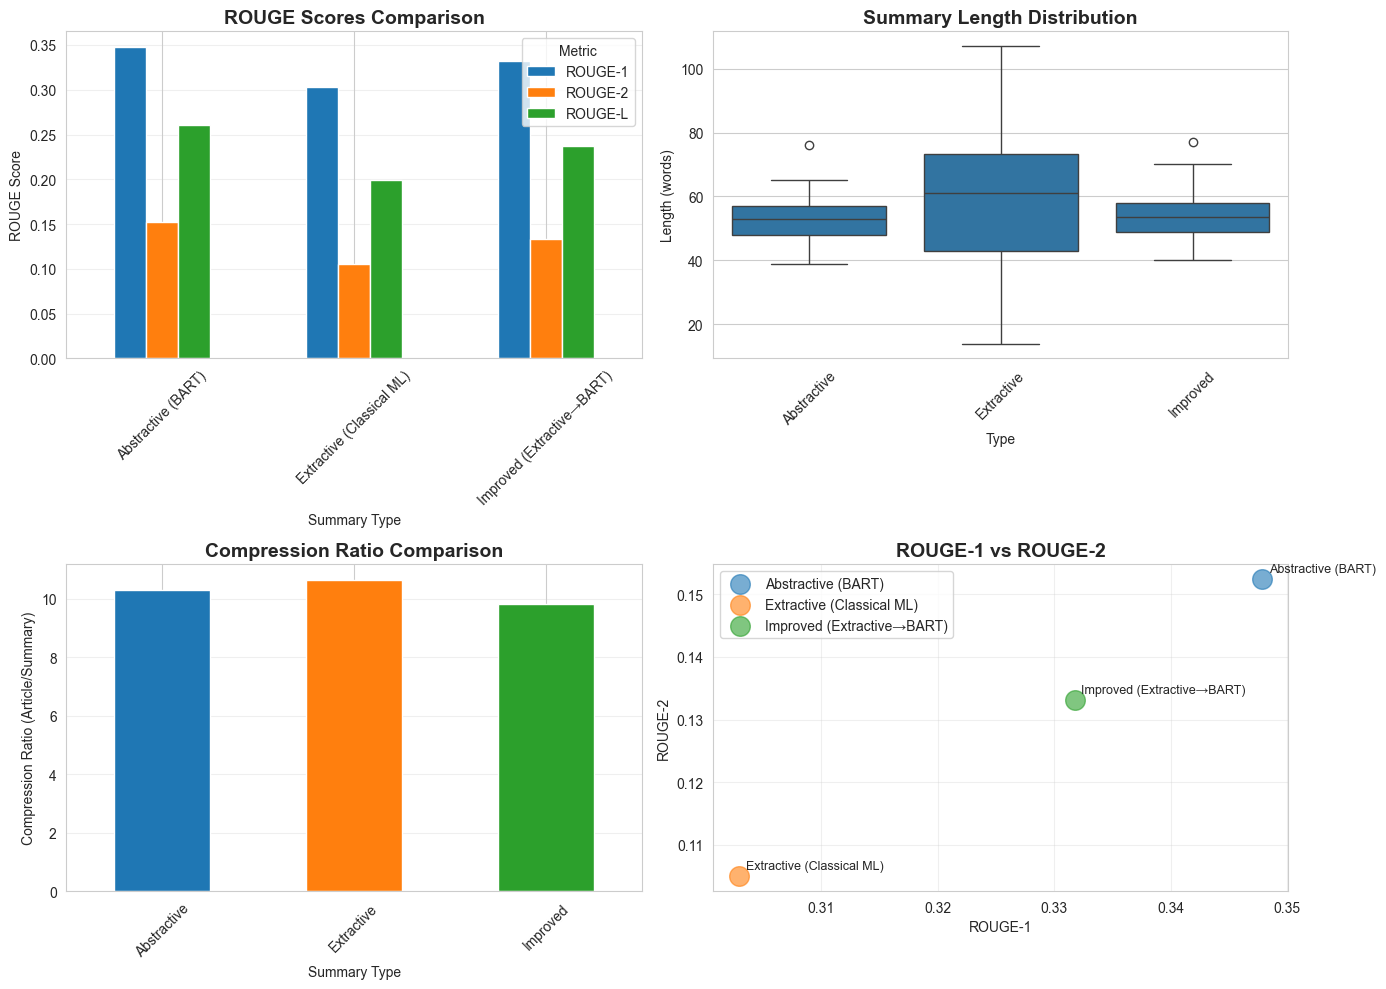

In [26]:

# CELL 24 — Visualization of Results

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

if 'rouge_comparison' in globals():
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 10)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. ROUGE Scores Comparison (Bar plot)
    ax1 = axes[0, 0]
    rouge_comparison.set_index('Summary Type')[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']].plot(
        kind='bar', ax=ax1, rot=45
    )
    ax1.set_title('ROUGE Scores Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('ROUGE Score')
    ax1.legend(title='Metric')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Summary Length Distribution (Box plot)
    ax2 = axes[0, 1]
    if test_summaries_df is not None:
        length_data = []
        for stype in ['abstractive', 'extractive', 'improved']:
            lengths = valid_df[stype].apply(lambda x: len(x.split())).tolist()
            length_data.extend([(stype.capitalize(), l) for l in lengths])
        
        length_df = pd.DataFrame(length_data, columns=['Type', 'Length'])
        sns.boxplot(data=length_df, x='Type', y='Length', ax=ax2)
        ax2.set_title('Summary Length Distribution', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Length (words)')
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. Compression Ratio Comparison (Bar plot)
    ax3 = axes[1, 0]
    if 'metrics_df' in globals():
        metrics_df.set_index('Summary Type')['Compression Ratio'].plot(
            kind='bar', ax=ax3, color=['#1f77b4', '#ff7f0e', '#2ca02c'], rot=45
        )
        ax3.set_title('Compression Ratio Comparison', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Compression Ratio (Article/Summary)')
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. ROUGE-1 vs ROUGE-2 Scatter
    ax4 = axes[1, 1]
    if 'rouge_comparison' in globals():
        scatter_data = rouge_comparison[['Summary Type', 'ROUGE-1', 'ROUGE-2']]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        for idx, row in scatter_data.iterrows():
            ax4.scatter(row['ROUGE-1'], row['ROUGE-2'], 
                       s=200, alpha=0.6, c=colors[idx], 
                       label=row['Summary Type'])
            ax4.annotate(row['Summary Type'], 
                        (row['ROUGE-1'], row['ROUGE-2']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9)
        ax4.set_xlabel('ROUGE-1')
        ax4.set_ylabel('ROUGE-2')
        ax4.set_title('ROUGE-1 vs ROUGE-2', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('summary_evaluation_results.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'summary_evaluation_results.png'")
    plt.show()

In [27]:

# CELL 25 — Save Complete Evaluation Report

print("\n" + "="*70)
print("SAVING EVALUATION REPORT")
print("="*70)

report_filename = "evaluation_report.txt"

with open(report_filename, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("COMPREHENSIVE EVALUATION REPORT\n")
    f.write("Auto-Notes Generation System\n")
    f.write("="*70 + "\n\n")
    
    # 1. Regression Model Performance
    f.write("1. REGRESSION MODEL (Summary Length Prediction)\n")
    f.write("-"*70 + "\n")
    if 'reg_results_df' in globals():
        f.write(reg_results_df.to_string(index=False))
        f.write("\n\n")
    
    # 2. Sentence Classification Performance
    f.write("2. SENTENCE CLASSIFICATION MODEL\n")
    f.write("-"*70 + "\n")
    if 'y_test_s' in globals() and 'final_sentence_model' in globals():
        # Get predictions on test set
        if hasattr(final_sentence_model, "predict_proba"):
            probs = final_sentence_model.predict_proba(X_test_s)[:,1]
        elif hasattr(final_sentence_model, "decision_function"):
            df = final_sentence_model.decision_function(X_test_s)
            probs = 1/(1+np.exp(-df))
        else:
            probs = final_sentence_model.predict(X_test_s).astype(float)
        
        preds = (probs >= best_threshold).astype(int)
        
        f.write(f"Model: {type(final_sentence_model).__name__}\n")
        f.write(f"Threshold: {best_threshold:.3f}\n\n")
        f.write("Test Set Performance:\n")
        f.write(f"  Accuracy:  {accuracy_score(y_test_s, preds):.4f}\n")
        f.write(f"  Precision: {precision_score(y_test_s, preds, zero_division=0):.4f}\n")
        f.write(f"  Recall:    {recall_score(y_test_s, preds, zero_division=0):.4f}\n")
        f.write(f"  F1-Score:  {f1_score(y_test_s, preds, zero_division=0):.4f}\n\n")
    
    # 3. ROUGE Scores
    f.write("3. ROUGE SCORES (Summary Quality)\n")
    f.write("-"*70 + "\n")
    if 'rouge_comparison' in globals():
        f.write(rouge_comparison.to_string(index=False))
        f.write("\n\n")
        
        # Best performers
        f.write("Best Performing Methods:\n")
        for metric in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
            best_idx = rouge_comparison[metric].idxmax()
            best_method = rouge_comparison.loc[best_idx, 'Summary Type']
            best_score = rouge_comparison.loc[best_idx, metric]
            f.write(f"  {metric}: {best_method} ({best_score:.4f})\n")
        f.write("\n")
    
    # 4. Additional Metrics
    f.write("4. SUMMARY STATISTICS\n")
    f.write("-"*70 + "\n")
    if 'metrics_df' in globals():
        f.write(metrics_df.to_string(index=False))
        f.write("\n\n")
    
    # 5. Sample Outputs
    f.write("5. SAMPLE OUTPUTS (First 3 Test Examples)\n")
    f.write("-"*70 + "\n")
    if test_summaries_df is not None and len(valid_df) > 0:
        for i in range(min(3, len(valid_df))):
            f.write(f"\nExample {i+1}:\n")
            f.write("-" * 50 + "\n")
            f.write(f"REFERENCE:\n{valid_df.iloc[i]['reference'][:300]}...\n\n")
            f.write(f"ABSTRACTIVE:\n{valid_df.iloc[i]['abstractive'][:300]}...\n\n")
            f.write(f"EXTRACTIVE:\n{valid_df.iloc[i]['extractive'][:300]}...\n\n")
            f.write(f"IMPROVED:\n{valid_df.iloc[i]['improved'][:300]}...\n\n")

print(f"Complete evaluation report saved to '{report_filename}'")
print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)


SAVING EVALUATION REPORT
Complete evaluation report saved to 'evaluation_report.txt'

EVALUATION COMPLETE
